# graph regularization for sentiment classification using synthesized graphs
___________________________
https://www.tensorflow.org/neural_structured_learning/tutorials/graph_keras_lstm_imdb

In [1]:
# Requirements
!pip install --quiet tensorflow==2.0.0-rc0
!pip install --quiet neural-structured-learning
!pip install --quiet tensorflow-hub

     |████████████████████████████████| 86.3MB 1.2MB/s 
     |████████████████████████████████| 501kB 49.8MB/s 
     |████████████████████████████████| 4.3MB 39.7MB/s 
     |████████████████████████████████| 92kB 4.1MB/s 


In [1]:
# Dependencies and imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import matplotlib.pyplot as plt
import numpy as np

import neural_structured_learning as nsl

import tensorflow as tf
tf.compat.v1.enable_v2_behavior()

import tensorflow_hub as hub

# Resets notebook state
tf.keras.backend.clear_session()

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0-rc0
Eager mode:  True
Hub version:  0.6.0
GPU is NOT AVAILABLE


In [2]:
# IMDB dataset
imdb = tf.keras.datasets.imdb
(pp_train_data, pp_train_labels), (pp_test_data, pp_test_labels) = (
    imdb.load_data(num_words=10000))

17465344/17464789 [==============================] - 0s 0us/step


In [3]:
# Explore the dataset
print('Training entries: {}, labels: {}'.format(
    len(pp_train_data), len(pp_train_labels)))
training_samples_count = len(pp_train_data)
print(pp_train_data[0])
print(len(pp_train_data[0]), len(pp_train_data[1]))

Training entries: 25000, labels: 25000
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
218 189


In [4]:
# convert the integers back to words
def build_reverse_word_index():
  # A dictionary mapping words to an integer index
  word_index = imdb.get_word_index()
  
  # the first indices are reserved
  word_index = {k: (v+3) for k, v in word_index.items()}
  word_index['<PAD>'] = 0
  word_index['<START>'] = 1
  word_index['<UNK>'] = 2 # unknown
  word_index['<UNUSED>'] = 3
  return dict((value, key) for (key, value) in word_index.items())

reverse_word_index = build_reverse_word_index()

def decode_review(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


In [5]:
decode_review(pp_train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [0]:
# Graph construction
!mkdir -p /tmp/imdb

In [0]:
# this is necessary because hub.keraslayer assumes tensor hashability, which
# is not supported in eager mode.
tf.compat.v1.disable_tensor_equality()

pretrained_embedding = 'https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1'

hub_layer = hub.KerasLayer(
    pretrained_embedding, input_shape=[], dtype=tf.string, trainable=True)

In [8]:
def _int64_feature(value):
  """Returns int64 tf.train.Feature."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value.tolist()))

def _bytes_feature(value):
  """Returns bytes tf.train.Feature."""
  return tf.train.Feature(
      bytes_list=tf.train.BytesList(value=[value.encode('utf-8')]))

def _float_feature(value):
  """Returns float tf.train.Feature."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=value.tolist()))

def create_embedding_example(word_vector, record_id):
  """Create tf.Example containing the sample's embedding and its ID."""
  
  text = decode_review(word_vector)
  
  # shape = [batch_size, ].
  sentence_embedding = hub_layer(tf.reshape(text, shape=[-1,]))
  
  # flatten the sentence embedding back to 1-D.
  sentence_embedding = tf.reshape(sentence_embedding, shape=[-1])
  
  features={
      'id': _bytes_feature(str(record_id)),
      'embedding': _float_feature(sentence_embedding.numpy())
  }
  return tf.train.Example(features=tf.train.Features(feature=features))

def create_embeddings(word_vectors, output_path, starting_record_id):
  record_id = int(starting_record_id)
  with tf.io.TFRecordWriter(output_path) as writer:
    for word_vector in word_vectors:
      example = create_embedding_example(word_vector, record_id)
      record_id = record_id + 1
      writer.write(example.SerializeToString())
  return record_id

# persist tf.example features containing embeddings for training data in 
# tfrecord format.
create_embeddings(pp_train_data, '/tmp/imdb/embeddings.tfr', 0)

25000

In [9]:
# build a graph
!python -m neural_structured_learning.tools.build_graph \
--similarity_threshold=0.99 /tmp/imdb/embeddings.tfr /tmp/imdb/graph_99.tsv

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'neural_structured_learning.tools.build_graph' found in sys.modules after import of package 'neural_structured_learning.tools', but prior to execution of 'neural_structured_learning.tools.build_graph'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
Reading tf.train.Examples from TFRecord file: /tmp/imdb/embeddings.tfr...
2019-09-13 13:17:09.219856: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-09-13 13:17:09.223955: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-09-13 13:17:09.224165: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x21ad2c0 executing computations on platform Host. Devices:
2019-09-13 13:17:09.224197: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
Done reading 25000 tf.train.Examples

In [10]:
# sample features
def create_example(word_vector, label, record_id):
  """Create tf.Example containing the sample's word vector, label, and ID."""
  features = {
      'id': _bytes_feature(str(record_id)),
      'words': _int64_feature(np.asarray(word_vector)),
      'label': _int64_feature(np.asarray([label])),
  }
  return tf.train.Example(features=tf.train.Features(feature=features))

def create_records(word_vectors, labels, record_path, starting_record_id):
  record_id = int(starting_record_id)
  with tf.io.TFRecordWriter(record_path) as writer:
    for word_vector, label in zip(word_vectors, labels):
      example = create_example(word_vector, label, record_id)
      record_id = record_id + 1
      writer.write(example.SerializeToString())
  return record_id

# Persist TF.Example features (word vectors and labels) for training and test
# data in TFRecord format.
next_record_id = create_records(pp_train_data, pp_train_labels,
                                '/tmp/imdb/train_data.tfr', 0)
create_records(pp_test_data, pp_test_labels, '/tmp/imdb/test_data.tfr',
               next_record_id)

50000

In [11]:
# augment training data with graph neighbors

!python -m neural_structured_learning.tools.pack_nbrs \
--max_nbrs=3 --add_undirected_edges=True \
/tmp/imdb/train_data.tfr '' /tmp/imdb/graph_99.tsv \
/tmp/imdb/nsl_train_data.tfr

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'neural_structured_learning.tools.pack_nbrs' found in sys.modules after import of package 'neural_structured_learning.tools', but prior to execution of 'neural_structured_learning.tools.pack_nbrs'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
Reading tf.train.Examples from TFRecord file: /tmp/imdb/train_data.tfr...
2019-09-13 13:21:40.489070: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-09-13 13:21:40.493138: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-09-13 13:21:40.493341: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x19c92c0 executing computations on platform Host. Devices:
2019-09-13 13:21:40.493372: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
Done reading 25000 tf.train.Examples fro

In [0]:
# base model
# global variables
NBR_FEATURE_PREFIX = 'NL_nbr_'
NBR_WEIGHT_SUFFIX = '_weight'

In [0]:
# Hyperparameters
class HParams(object):
  """Hyperparameters used for training."""
  def __init__(self):
    ### dataset parameters
    self.num_classes = 2
    self.max_seq_length = 256
    self.vocab_size = 10000
    ### neural graph learning parameters
    self.distance_type = nsl.configs.DistanceType.L2
    self.graph_regularization_multiplier = 0.1
    self.num_neighbors = 2
    ### model architecture
    self.num_embedding_dims = 16
    self.num_lstm_dims = 64
    self.num_fc_units = 64
    ### training parameters
    self.train_epochs = 10
    self.batch_size = 128
    ### eval parameters
    self.eval_steps = None # all instances in the test set are evaluated.
    
HPARAMS = HParams()

In [0]:
# prepare the data
def pad_sequence(sequence, max_seq_length):
  """Pads the input sequence (a `tf.SparseTensor`) to `max_seq_length`."""
  pad_size = tf.maximum([0], max_seq_length - tf.shape(sequence)[0])
  padded = tf.concat(
      [sequence.values,
       tf.fill((pad_size), tf.cast(0, sequence.dtype))],
      axis=0)
  # The input sequence may be larger than max_seq_length. Truncate down if
  # necessary.
  return tf.slice(padded, [0], [max_seq_length])

def parse_example(example_proto):
  """Extracts relevant fields from the `example_proto`.

  Args:
    example_proto: An instance of `tf.train.Example`.

  Returns:
    A pair whose first value is a dictionary containing relevant features
    and whose second value contains the ground truth labels.
  """
  # The 'words' feature is a variable length word ID vector.
  feature_spec = {
      'words': tf.io.VarLenFeature(tf.int64),
      'label': tf.io.FixedLenFeature((), tf.int64, default_value=-1),
  }
  # We also extract corresponding neighbor features in a similar manner to
  # the features above.
  for i in range(HPARAMS.num_neighbors):
    nbr_feature_key = '{}{}_{}'.format(NBR_FEATURE_PREFIX, i, 'words')
    nbr_weight_key = '{}{}{}'.format(NBR_FEATURE_PREFIX, i, NBR_WEIGHT_SUFFIX)
    feature_spec[nbr_feature_key] = tf.io.VarLenFeature(tf.int64)

    # We assign a default value of 0.0 for the neighbor weight so that
    # graph regularization is done on samples based on their exact number
    # of neighbors. In other words, non-existent neighbors are discounted.
    feature_spec[nbr_weight_key] = tf.io.FixedLenFeature(
        [1], tf.float32, default_value=tf.constant([0.0]))

  features = tf.io.parse_single_example(example_proto, feature_spec)

  # Since the 'words' feature is a variable length word vector, we pad it to a
  # constant maximum length based on HPARAMS.max_seq_length
  features['words'] = pad_sequence(features['words'], HPARAMS.max_seq_length)
  for i in range(HPARAMS.num_neighbors):
    nbr_feature_key = '{}{}_{}'.format(NBR_FEATURE_PREFIX, i, 'words')
    features[nbr_feature_key] = pad_sequence(features[nbr_feature_key],
                                             HPARAMS.max_seq_length)

  labels = features.pop('label')
  return features, labels

def make_dataset(file_path, training=False):
  """Creates a `tf.data.TFRecordDataset`.

  Args:
    file_path: Name of the file in the `.tfrecord` format containing
      `tf.train.Example` objects.
    training: Boolean indicating if we are in training mode.

  Returns:
    An instance of `tf.data.TFRecordDataset` containing the `tf.train.Example`
    objects.
  """
  dataset = tf.data.TFRecordDataset([file_path])
  if training:
    dataset = dataset.shuffle(10000)
  dataset = dataset.map(parse_example)
  dataset = dataset.batch(HPARAMS.batch_size)
  return dataset

train_dataset = make_dataset('/tmp/imdb/nsl_train_data.tfr', True)
test_dataset = make_dataset('/tmp/imdb/test_data.tfr')

In [15]:
# build the model
# this function exists as an alternative to the bi-LSTM model used in this
# notebook
# This function exists as an alternative to the bi-LSTM model used in this
# notebook.
def make_feed_forward_model():
  """Builds a simple 2 layer feed forward neural network."""
  inputs = tf.keras.Input(
      shape=(HPARAMS.max_seq_length,), dtype='int64', name='words')
  embedding_layer = tf.keras.layers.Embedding(HPARAMS.vocab_size, 16)(inputs)
  pooling_layer = tf.keras.layers.GlobalAveragePooling1D()(embedding_layer)
  dense_layer = tf.keras.layers.Dense(16, activation='relu')(pooling_layer)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer)
  return tf.keras.Model(inputs=inputs, outputs=outputs)


def make_bilstm_model():
  """Builds a bi-directional LSTM model."""
  inputs = tf.keras.Input(
      shape=(HPARAMS.max_seq_length,), dtype='int64', name='words')
  embedding_layer = tf.keras.layers.Embedding(HPARAMS.vocab_size,
                                              HPARAMS.num_embedding_dims)(
                                                  inputs)
  lstm_layer = tf.keras.layers.Bidirectional(
      tf.keras.layers.LSTM(HPARAMS.num_lstm_dims))(
          embedding_layer)
  dense_layer = tf.keras.layers.Dense(
      HPARAMS.num_fc_units, activation='relu')(
          lstm_layer)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer)
  return tf.keras.Model(inputs=inputs, outputs=outputs)


# Feel free to use an architecture of your choice.
model = make_bilstm_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
words (InputLayer)           [(None, 256)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 256, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               41472     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 209,793
Trainable params: 209,793
Non-trainable params: 0
_________________________________________________________________


In [0]:
# loss function and optimizer
model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
# create a validation set
validation_fraction = 0.9
validation_size = int(validation_fraction *
                      int(training_samples_count / HPARAMS.batch_size))
print(validation_size)
validation_dataset = train_dataset.take(validation_size)
train_dataset = train_dataset.skip(validation_size)

175


In [18]:
# train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=HPARAMS.train_epochs,
    verbose=1)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


21/21 [==============================] - 59s 3s/step - loss: 0.6936 - accuracy: 0.4958 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
21/21 [==============================] - 55s 3s/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/10
21/21 [==============================] - 55s 3s/step - loss: 0.6897 - accuracy: 0.5800 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/10
21/21 [==============================] - 55s 3s/step - loss: 0.6312 - accuracy: 0.6588 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/10
21/21 [==============================] - 55s 3s/step - loss: 0.4947 - accuracy: 0.7662 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/10
21/21 [==============================] - 55s 3s/step - loss: 0.3815 - accuracy: 0.8381 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/10
21/21 [==============================] - 55s 3s/step - loss: 0.3577 - accuracy: 0.8588 - val_loss: 0.0000e+00 - 

In [19]:
# evaluate the model
results = model.evaluate(test_dataset, steps=HPARAMS.eval_steps)
print(results)

196/196 [==============================] - 43s 220ms/step - loss: 0.3636 - accuracy: 0.8447
[0.36363303935041236, 0.84472]


In [20]:
# create a graph of accuracy/loss over time
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

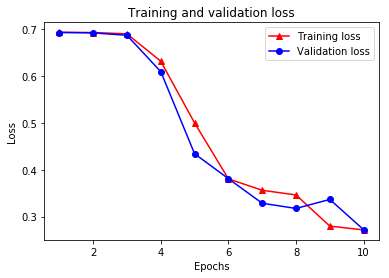

In [21]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "-r^" is for solid red line with triangle markers.
plt.plot(epochs, loss, '-r^', label='Training loss')
# "-b0" is for solid blue line with circle markers.
plt.plot(epochs, val_loss, '-bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

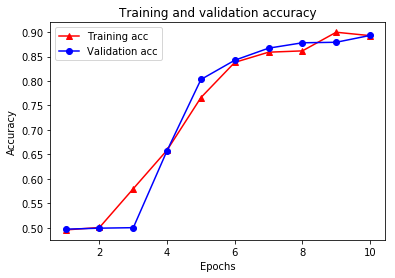

In [22]:
plt.clf()   # clear figure

plt.plot(epochs, acc, '-r^', label='Training acc')
plt.plot(epochs, val_acc, '-bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.show()

In [0]:
# graph regularization
# create graph-regularized model
# Build a new base LSTM model.
base_reg_model = make_bilstm_model()

In [0]:
# Wrap the base model with graph regularization.
graph_reg_config = nsl.configs.GraphRegConfig(
    neighbor_config=nsl.configs.GraphNeighborConfig(
        max_neighbors=HPARAMS.num_neighbors),
    multiplier=HPARAMS.graph_regularization_multiplier,
    distance_config=nsl.configs.DistanceConfig(
        distance_type=HPARAMS.distance_type, sum_over_axis=-1))
graph_reg_model = nsl.keras.GraphRegularization(base_reg_model,
                                                graph_reg_config)
graph_reg_model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
# train the model
graph_reg_history = graph_reg_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=HPARAMS.train_epochs,
    verbose=1)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


21/21 [==============================] - 89s 4s/step - loss: 0.6931 - accuracy: 0.5077 - graph_loss: 1.2091e-05 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_graph_loss: 0.0000e+00
Epoch 2/10
21/21 [==============================] - 78s 4s/step - loss: 0.6906 - accuracy: 0.5158 - graph_loss: 1.5608e-04 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_graph_loss: 0.0000e+00
Epoch 3/10
21/21 [==============================] - 78s 4s/step - loss: 0.6418 - accuracy: 0.6542 - graph_loss: 0.0167 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_graph_loss: 0.0000e+00
Epoch 4/10
21/21 [==============================] - 79s 4s/step - loss: 0.6413 - accuracy: 0.6477 - graph_loss: 0.0074 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_graph_loss: 0.0000e+00
Epoch 5/10
21/21 [==============================] - 79s 4s/step - loss: 0.5340 - accuracy: 0.7623 - graph_loss: 0.0567 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_graph_loss: 0.0000e+00
Epoch 6/10
21

In [27]:
# evaluate the model
graph_reg_results = graph_reg_model.evaluate(test_dataset, steps=HPARAMS.eval_steps)
print(graph_reg_results)

196/196 [==============================] - 52s 265ms/step - loss: 0.3761 - accuracy: 0.8464 - graph_loss: 0.0000e+00
[0.37613334134221077, 0.84636, 0.0]


In [28]:
# create a graph of accuracy/loss over time
graph_reg_history_dict = graph_reg_history.history
graph_reg_history_dict.keys()

dict_keys(['loss', 'accuracy', 'graph_loss', 'val_loss', 'val_accuracy', 'val_graph_loss'])

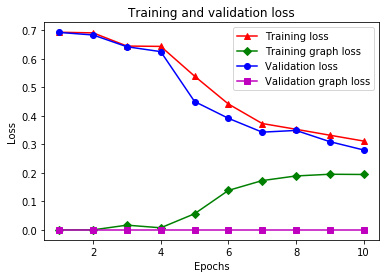

In [29]:
acc = graph_reg_history_dict['accuracy']
val_acc = graph_reg_history_dict['val_accuracy']
loss = graph_reg_history_dict['loss']
graph_loss = graph_reg_history_dict['graph_loss']
val_loss = graph_reg_history_dict['val_loss']
val_graph_loss = graph_reg_history_dict['val_graph_loss']

epochs = range(1, len(acc) + 1)

plt.clf()   # clear figure

# "-r^" is for solid red line with triangle markers.
plt.plot(epochs, loss, '-r^', label='Training loss')
# "-gD" is for solid green line with diamond markers.
plt.plot(epochs, graph_loss, '-gD', label='Training graph loss')
# "-b0" is for solid blue line with circle markers.
plt.plot(epochs, val_loss, '-bo', label='Validation loss')
# "-ms" is for solid magenta line with square markers.
plt.plot(epochs, val_graph_loss, '-ms', label='Validation graph loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

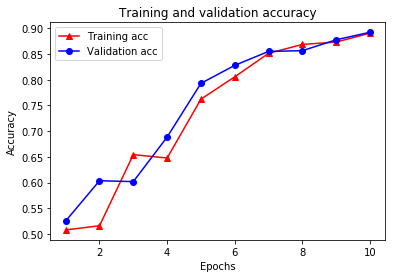

In [30]:
plt.clf()   # clear figure

plt.plot(epochs, acc, '-r^', label='Training acc')
plt.plot(epochs, val_acc, '-bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.show()

<Figure size 432x288 with 0 Axes>

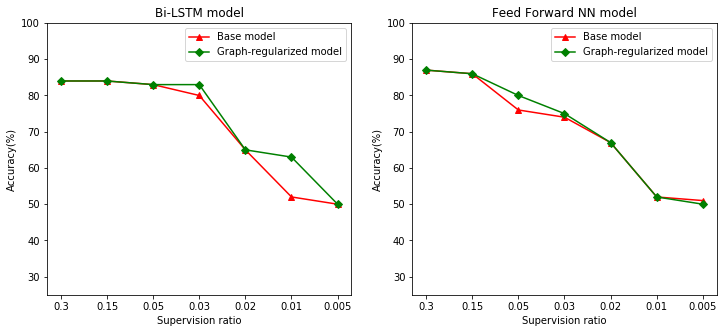

In [31]:
# power of semi-supervised learning
# Accuracy values for both the Bi-LSTM model and the feed forward NN model have
# been precomputed for the following supervision ratios.

supervision_ratios = [0.3, 0.15, 0.05, 0.03, 0.02, 0.01, 0.005]

model_tags = ['Bi-LSTM model', 'Feed Forward NN model']
base_model_accs = [[84, 84, 83, 80, 65, 52, 50], [87, 86, 76, 74, 67, 52, 51]]
graph_reg_model_accs = [[84, 84, 83, 83, 65, 63, 50],
                        [87, 86, 80, 75, 67, 52, 50]]

plt.clf()  # clear figure

fig, axes = plt.subplots(1, 2)
fig.set_size_inches((12, 5))

for ax, model_tag, base_model_acc, graph_reg_model_acc in zip(
    axes, model_tags, base_model_accs, graph_reg_model_accs):

  # "-r^" is for solid red line with triangle markers.
  ax.plot(base_model_acc, '-r^', label='Base model')
  # "-gD" is for solid green line with diamond markers.
  ax.plot(graph_reg_model_acc, '-gD', label='Graph-regularized model')
  ax.set_title(model_tag)
  ax.set_xlabel('Supervision ratio')
  ax.set_ylabel('Accuracy(%)')
  ax.set_ylim((25, 100))
  ax.set_xticks(range(len(supervision_ratios)))
  ax.set_xticklabels(supervision_ratios)
  ax.legend(loc='best')

plt.show()